<a href="https://colab.research.google.com/github/psaikrupa/TelecomChurn-KaggleCompetition/blob/main/TelecomChurnPrediction_Sai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telecom Churn Prediction**
by Saikrupa Purushothaman

## **Introduction**

In the telecommunication industry, customers tend to change operators if not provided with attractive schemes and offers. It is very important for any telecom operator to prevent the present customers from churning to other operators. This case study is to build an ML model which can predict if the customer will churn or not in a particular month based on the past data.

## **Objective**

Objective of the case study is to

- evaluate multiple models and predict if a high value customer will churn or not
- Calculate other relevant metrics for the evaluated models
- Identify the most important features
- Recommend strategies to manage customer churn based on your observations.

## Dataset

Two sets of data has been provided for this case study.
train.csv - This is the data to be used to train the model
test.csv - This is the unseen data that will be used to test the model



### **Step 1 - Importing required libraries**

In [40]:
## Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score ,confusion_matrix, precision_score, f1_score, recall_score ,classification_report,accuracy_score, roc_curve, auc

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### **Step 2 - Function Definitions**

Define reusable functions to modularize the code

In [41]:
#### Function to handle null values
def handlingnullvalues(df_train):
    ### Remove rows with date columns having NULL values
    #df_train = df_train[~df_train[lst_date_columns].isnull().any(axis=1)]

    ### For recharge related columns (float) - replace Null values with 0
    df_train[lst_float_columns] = df_train[lst_float_columns].apply(lambda x: x.fillna(0))
    (df_train[lst_float_columns].isna().sum()).sort_values(ascending=False)

    ### For service scheme related columns (categorical) - replace Null values with -1
    df_train[lst_serviceschemes_columns] = df_train[lst_serviceschemes_columns].apply(lambda x: x.fillna(-1))
    (df_train[lst_serviceschemes_columns].isna().sum()).sort_values(ascending=False)

    ### For usage columns related columns (numerical) - replace Null values with 0
    df_train[lst_otherint_columns] = df_train[lst_otherint_columns].apply(lambda x: x.fillna(0))
    (df_train[lst_otherint_columns].isna().sum()).sort_values(ascending=False)

    return df_train

#### Function to handle columns with low cardinality
def handlelowcardinality(df_train,lst_lessuniquevalues):
    df_train = df_train.drop(lst_lessuniquevalues, axis=1)
    return df_train

#### Function to handle columns with high cardinality
def handlehighcardinality(df_train,lst_highuniquevalues):
    df_train = df_train.drop(lst_highuniquevalues, axis=1)
    return df_train

#### Function to change datatype of the date columns to datetime
def changedtypefordatecols(df_train,lst_datecolumns2,formatstr):
    for d in lst_datecolumns2:
        df_train[d] = pd.to_datetime(df_train[d], format=formatstr)
    return df_train

#### Function to create new meaningful columns from the existing data

def creatderivedcolumns(df_train):
    ## Recharge Counts
    df_train['total_rech_num_change'] = df_train['total_rech_num_8'] - ((df_train['total_rech_num_6'] + df_train['total_rech_num_7'])/2)
    df_train['total_rech_data_change'] = df_train['total_rech_data_8'] - ((df_train['total_rech_data_6'] + df_train['total_rech_data_7'])/2)
    df_train['max_rech_data_change'] = df_train['max_rech_data_8'] - ((df_train['max_rech_data_6'] + df_train['max_rech_data_7'])/2)
    df_train['count_rech_2g_change'] = df_train['count_rech_2g_8'] - ((df_train['count_rech_2g_6'] + df_train['count_rech_2g_7'])/2)
    df_train['count_rech_3g_change'] = df_train['count_rech_3g_8'] - ((df_train['count_rech_3g_6'] + df_train['count_rech_3g_7'])/2)

    ## Recharge Amounts
    df_train['total_rech_amt_change'] = df_train['total_rech_amt_8'] - ((df_train['total_rech_amt_6'] + df_train['total_rech_amt_7'])/2)
    df_train['max_rech_amt_change'] = df_train['max_rech_amt_8'] - ((df_train['max_rech_amt_6'] + df_train['max_rech_amt_7'])/2)
    df_train['last_day_rch_amt_change'] = df_train['last_day_rch_amt_8'] - ((df_train['last_day_rch_amt_6'] + df_train['last_day_rch_amt_7'])/2)
    df_train['av_rech_amt_data_change'] = df_train['av_rech_amt_data_8'] - ((df_train['av_rech_amt_data_6'] + df_train['av_rech_amt_data_7'])/2)
    df_train['arpu_change'] = df_train['arpu_8'] - ((df_train['arpu_6'] + df_train['arpu_7'])/2)
    df_train['arpu_3g_change'] = df_train['arpu_3g_8'] - ((df_train['arpu_3g_6'] + df_train['arpu_3g_7'])/2)
    df_train['arpu_2g_change'] = df_train['arpu_2g_8'] - ((df_train['arpu_2g_6'] + df_train['arpu_2g_7'])/2)
    df_train['vbc_3g_change'] = df_train['aug_vbc_3g'] - ((df_train['jun_vbc_3g'] + df_train['jul_vbc_3g'])/2)

    ## Usage
    df_train['onnet_mou_change'] = df_train['onnet_mou_8'] - ((df_train['onnet_mou_6'] + df_train['onnet_mou_7'])/2)
    df_train['offnet_mou_change'] = df_train['offnet_mou_8'] - ((df_train['offnet_mou_6'] + df_train['offnet_mou_7'])/2)
    df_train['roam_ic_mou_change'] = df_train['roam_ic_mou_8'] - ((df_train['roam_ic_mou_6'] + df_train['roam_ic_mou_7'])/2)
    df_train['roam_og_mou_change'] = df_train['roam_og_mou_8'] - ((df_train['roam_og_mou_6'] + df_train['roam_og_mou_7'])/2)
    df_train['loc_og_t2t_mou_change'] = df_train['loc_og_t2t_mou_8'] - ((df_train['loc_og_t2t_mou_6'] + df_train['loc_og_t2t_mou_7'])/2)
    df_train['loc_og_t2m_mou_change'] = df_train['loc_og_t2m_mou_8'] - ((df_train['loc_og_t2m_mou_6'] + df_train['loc_og_t2m_mou_7'])/2)
    df_train['loc_og_t2f_mou_change'] = df_train['loc_og_t2f_mou_8'] - ((df_train['loc_og_t2f_mou_6'] + df_train['loc_og_t2f_mou_7'])/2)
    df_train['loc_og_t2c_mou_change'] = df_train['loc_og_t2c_mou_8'] - ((df_train['loc_og_t2c_mou_6'] + df_train['loc_og_t2c_mou_7'])/2)
    df_train['loc_og_mou_change'] = df_train['loc_og_mou_8'] - ((df_train['loc_og_mou_6'] + df_train['loc_og_mou_7'])/2)
    df_train['std_og_t2t_mou_change'] = df_train['std_og_t2t_mou_8'] - ((df_train['std_og_t2t_mou_6'] + df_train['std_og_t2t_mou_7'])/2)
    df_train['std_og_t2m_mou_change'] = df_train['std_og_t2m_mou_8'] - ((df_train['std_og_t2m_mou_6'] + df_train['std_og_t2m_mou_7'])/2)
    df_train['std_og_t2f_mou_change'] = df_train['std_og_t2f_mou_8'] - ((df_train['std_og_t2f_mou_6'] + df_train['std_og_t2f_mou_7'])/2)

    df_train['std_og_mou_change'] = df_train['std_og_mou_8'] - ((df_train['std_og_mou_6'] + df_train['std_og_mou_7'])/2)
    df_train['isd_og_mou_change'] = df_train['isd_og_mou_8'] - ((df_train['isd_og_mou_6'] + df_train['isd_og_mou_7'])/2)
    df_train['spl_og_mou_change'] = df_train['spl_og_mou_8'] - ((df_train['spl_og_mou_6'] + df_train['spl_og_mou_7'])/2)
    df_train['total_og_mou_change'] = df_train['total_og_mou_8'] - ((df_train['total_og_mou_6'] + df_train['total_og_mou_7'])/2)
    df_train['loc_ic_t2t_mou_change'] = df_train['loc_ic_t2t_mou_8'] - ((df_train['loc_ic_t2t_mou_6'] + df_train['loc_ic_t2t_mou_7'])/2)
    df_train['loc_ic_t2m_mou_change'] = df_train['loc_ic_t2m_mou_8'] - ((df_train['loc_ic_t2m_mou_6'] + df_train['loc_ic_t2m_mou_7'])/2)
    df_train['loc_ic_t2f_mou_change'] = df_train['loc_ic_t2f_mou_8'] - ((df_train['loc_ic_t2f_mou_6'] + df_train['loc_ic_t2f_mou_7'])/2)
    df_train['loc_ic_mou_change'] = df_train['loc_ic_mou_8'] - ((df_train['loc_ic_mou_6'] + df_train['loc_ic_mou_7'])/2)
    df_train['std_ic_t2t_mou_change'] = df_train['std_ic_t2t_mou_8'] - ((df_train['std_ic_t2t_mou_6'] + df_train['std_ic_t2t_mou_7'])/2)
    df_train['std_ic_t2m_mou_change'] = df_train['std_ic_t2m_mou_8'] - ((df_train['std_ic_t2m_mou_6'] + df_train['std_ic_t2m_mou_7'])/2)
    df_train['std_ic_t2f_mou_change'] = df_train['std_ic_t2f_mou_8'] - ((df_train['std_ic_t2f_mou_6'] + df_train['std_ic_t2f_mou_7'])/2)

    df_train['std_ic_mou_change'] = df_train['std_ic_mou_8'] - ((df_train['std_ic_mou_6'] + df_train['std_ic_mou_7'])/2)
    df_train['total_ic_mou_change'] = df_train['total_ic_mou_8'] - ((df_train['total_ic_mou_6'] + df_train['total_ic_mou_7'])/2)
    df_train['spl_ic_mou_change'] = df_train['spl_ic_mou_8'] - ((df_train['spl_ic_mou_6'] + df_train['spl_ic_mou_7'])/2)
    df_train['isd_ic_mou_change'] = df_train['isd_ic_mou_8'] - ((df_train['isd_ic_mou_6'] + df_train['isd_ic_mou_7'])/2)

    ## Other numeric columns
    df_train['og_others_change'] = df_train['og_others_8'] - ((df_train['og_others_6'] + df_train['og_others_7'])/2)
    df_train['ic_others_change'] = df_train['ic_others_8'] - ((df_train['ic_others_6'] + df_train['ic_others_7'])/2)
    df_train['vol_2g_mb_change'] = df_train['vol_2g_mb_8'] - ((df_train['vol_2g_mb_6'] + df_train['vol_2g_mb_7'])/2)
    df_train['vol_3g_mb_change'] = df_train['vol_3g_mb_8'] - ((df_train['vol_3g_mb_6'] + df_train['vol_3g_mb_7'])/2)

    ## Total Spend
    df_train['total_spend'] = df_train['total_rech_amt_6'] + df_train['total_rech_amt_7'] + df_train['total_rech_amt_8'] + df_train['total_rech_data_6'] + df_train['total_rech_data_7'] + df_train['total_rech_data_8']

    return df_train

#### Function to drop columns that have high NULL values based on a threshold
def dropcolumnsbasedondatathreshold(df_train, threshold_nonnullrows):
    initial_cols = df_train.shape[1]
    include_cols = list(df_train.apply(lambda column: True if column.isnull().sum()/df_train.shape[0] < threshold_nonnullrows else False))

    drop_cols = pd.DataFrame({'features':df_train.columns , 'include': include_cols})
    drop_cols.loc[drop_cols.include == True,:]

    # drop columns
    df_train = df_train.loc[:, include_cols]

    return df_train

#### Function to drop columns not useful after deriving additional information
def dropredundantcolumns(df_train):
    ## Remove the columns used in the above calculations as they are not needed anymore
    lst_rech_dropcols = ['total_rech_num_8','total_rech_num_6','total_rech_num_7','total_rech_data_8','total_rech_data_6','total_rech_data_7','max_rech_data_8','max_rech_data_6','max_rech_data_7','count_rech_2g_8','count_rech_2g_6','count_rech_2g_7','count_rech_3g_8','count_rech_3g_6','count_rech_3g_7']
    lst_rechamt_dropcols = ['total_rech_amt_8','total_rech_amt_6','total_rech_amt_7','max_rech_amt_8','max_rech_amt_6','max_rech_amt_7','last_day_rch_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','av_rech_amt_data_8','av_rech_amt_data_6','av_rech_amt_data_7','arpu_8','arpu_6','arpu_7','arpu_3g_8','arpu_3g_6','arpu_3g_7','arpu_2g_8','arpu_2g_6','arpu_2g_7','aug_vbc_3g','jun_vbc_3g','jul_vbc_3g']
    lst_usage_dropcols = [
                       'onnet_mou_8','onnet_mou_6','onnet_mou_7','offnet_mou_8','offnet_mou_6','offnet_mou_7'
                       ,'roam_ic_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_8','roam_og_mou_6','roam_og_mou_7'
                       ,'loc_og_t2t_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7'
                       ,'loc_og_t2f_mou_8','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7'
                       ,'loc_og_mou_8','loc_og_mou_6','loc_og_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2m_mou_8'
                       ,'std_og_t2m_mou_8','std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_6','std_og_t2f_mou_7'
                       ,'std_og_mou_8','std_og_mou_6','std_og_mou_7','isd_og_mou_8','isd_og_mou_6','isd_og_mou_7'
                       ,'spl_og_mou_8','spl_og_mou_6','spl_og_mou_7','total_og_mou_8','total_og_mou_6','total_og_mou_7'
                       ,'loc_ic_t2t_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7'
                       ,'loc_ic_t2f_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_mou_8','loc_ic_mou_6','loc_ic_mou_7'
                       ,'std_ic_t2t_mou_8','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7'
                       ,'std_ic_t2f_mou_8','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_mou_8','std_ic_mou_6','std_ic_mou_7'
                       ,'total_ic_mou_8','total_ic_mou_6','total_ic_mou_7','spl_ic_mou_8','spl_ic_mou_6','spl_ic_mou_7'
                       ,'isd_ic_mou_8','isd_ic_mou_6','isd_ic_mou_7'
                       ]
    lst_others_dropcols = ['og_others_6','og_others_7','og_others_8','ic_others_6','ic_others_7','ic_others_8'
                          ,'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']


    df_train = df_train.drop(columns=lst_rech_dropcols,axis=1)
    df_train = df_train.drop(columns=lst_rechamt_dropcols,axis=1)
    df_train = df_train.drop(columns=lst_usage_dropcols,axis=1)
    df_train = df_train.drop(columns=lst_others_dropcols,axis=1)
    #df_train = df_train.drop(columns=lst_date_dropcols)

    return df_train

#### Function to determine high value customers based on their spend and a threshold value
def findinghighvaluecustomers(df_train, threshold_highvaluecustomer):
    threshold_value = df_train['total_spend'].quantile(threshold_highvaluecustomer)
    df_train = df_train[df_train['total_spend'] >= threshold_value]
    return df_train

#### Function to derive information based on recharge pattern
def lastrechargepattern(df_train):
     ## Get day for date columns
    df_train['last_recharge_day_6'] = df_train['date_of_last_rech_6'].dt.day
    df_train['last_recharge_day_7'] = df_train['date_of_last_rech_7'].dt.day
    df_train['last_recharge_day_8'] = df_train['date_of_last_rech_8'].dt.day
    df_train['last_recharge_pattern'] = (abs(df_train['last_recharge_day_6'] - df_train['last_recharge_day_7']) + abs(df_train['last_recharge_day_7'] - df_train['last_recharge_day_8']))/2
    df_train['last_recharge_pattern'] = df_train['last_recharge_pattern'].fillna(60)
    df_train = df_train.drop(columns=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','last_recharge_day_6','last_recharge_day_7','last_recharge_day_8'],axis=1)
    #df_train = df_train.drop(columns=['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1)

    return df_train

#### Function to preprocess data
def preprocessdata(data, datatype):
    print(data.shape)
    ### List of columns based on unique values
    lst_lessuniquevalues = data.columns[data.nunique() == 1]
    lst_highuniquevalues = ['id']

    ## Handling high & low cardinality values - Drop columns
    data = handlehighcardinality(data,lst_highuniquevalues)
    print("Shape after handling high cardinality columns -" , data.shape)
    data = handlelowcardinality(data,lst_lessuniquevalues)
    print("Shape after handling low cardinality columns -" , data.shape)

    ### List of columns based on datatypes
    lst_int_columns = data.select_dtypes(include=['int', 'int64']).columns
    lst_float_columns = data.select_dtypes(include=['float', 'float64']).columns
    lst_date_columns = data.select_dtypes(include=['object']).columns
    lst_serviceschemes_columns = ['night_pck_user_6','night_pck_user_7','night_pck_user_8','monthly_2g_6','monthly_2g_7','monthly_2g_8','sachet_2g_6'
                                  ,'sachet_2g_7','sachet_2g_8','monthly_3g_6','monthly_3g_7','monthly_3g_8','sachet_3g_6','sachet_3g_7','sachet_3g_8']
    lst_otherint_columns = list(set(lst_int_columns) - set(lst_serviceschemes_columns))

    ### For recharge related columns (float) - replace Null values with 0
    data[lst_float_columns] = data[lst_float_columns].apply(lambda x: x.fillna(0))
    (data[lst_float_columns].isna().sum()).sort_values(ascending=False)

    ### For service scheme related columns (categorical) - replace Null values with -1
    data[lst_serviceschemes_columns] = data[lst_serviceschemes_columns].apply(lambda x: x.fillna(-1))
    (data[lst_serviceschemes_columns].isna().sum()).sort_values(ascending=False)

    ### For usage columns related columns (numerical) - replace Null values with 0
    data[lst_otherint_columns] = data[lst_otherint_columns].apply(lambda x: x.fillna(0))
    (data[lst_otherint_columns].isna().sum()).sort_values(ascending=False)

    ## Handling columns with high NULL values - Drop Columns
    data = dropcolumnsbasedondatathreshold(data,0.7)
    print("Shape after handling columns with NULLs -" , data.shape)

    ## Remove rows with NULL values
    #data = data[~data.isnull().any(axis=1)]
    #print("Shape after handling rows with NULLs -" , data.shape)

    ### Change datatype of date columns
    lst_datecolumns = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
    data = changedtypefordatecols(data,lst_datecolumns,'%m/%d/%Y')
    print("Shape after handling date column formats -" , data.shape)

    ### Change additional columns
    data = creatderivedcolumns(data)
    print("Shape after deriving new columns -" , data.shape)

    ### if train data, filter dataset to include only high value customers
    if datatype == "train":
        data = findinghighvaluecustomers(data, 0.7)
        print("Shape after limiting the train dataset to high value customers -" , data.shape)

    ### remove unwanted columns
    data = dropredundantcolumns(data)
    print("Shape after dropping redundant columns -" , data.shape)

    ### Change datatype of date columns
    data = lastrechargepattern(data)
    print("Shape after deriving new column for last recharge pattern -" , data.shape)

    return data



## **Step 3 - Read train data**

In [42]:
### Read train and data from .csv file

pd.set_option('display.max_columns', None)

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print(df_train.shape)
print(df_test.shape)

(69999, 172)
(30000, 171)


### **Step 4 - Understanding data**

In [43]:
#### Understand non null value count and datatype of each column
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [44]:
#### Understanding the shape of the train and test data
print(df_train.shape)
print(df_test.shape)

(69999, 172)
(30000, 171)


In [45]:
### Finding unique value counts for each column
pd.set_option('display.max_rows', None)
df_train.nunique().sort_values(ascending=False)

id                          69999
arpu_6                      61615
arpu_7                      61425
arpu_8                      60194
total_og_mou_7              33195
total_og_mou_6              33135
total_og_mou_8              32897
total_ic_mou_6              27432
total_ic_mou_7              27418
total_ic_mou_8              27318
offnet_mou_6                26254
offnet_mou_7                26139
offnet_mou_8                25995
loc_ic_mou_6                24442
loc_ic_mou_7                24258
loc_ic_mou_8                24182
loc_og_mou_6                22309
std_og_mou_7                22088
loc_og_mou_7                22012
loc_og_mou_8                21950
std_og_mou_6                21837
std_og_mou_8                21745
onnet_mou_7                 20076
onnet_mou_6                 20057
onnet_mou_8                 19725
loc_ic_t2m_mou_6            19034
loc_ic_t2m_mou_8            19022
loc_ic_t2m_mou_7            18945
loc_og_t2m_mou_6            17848
loc_og_t2m_mou

In [46]:
#### Row count in the train dataset
len(df_train)

69999

In [47]:
#### Understand NULL values in each column of the dataset
df_train.isna().sum().sort_values(ascending=False)

arpu_3g_6                   52431
count_rech_2g_6             52431
night_pck_user_6            52431
arpu_2g_6                   52431
date_of_last_rech_data_6    52431
total_rech_data_6           52431
av_rech_amt_data_6          52431
max_rech_data_6             52431
count_rech_3g_6             52431
fb_user_6                   52431
night_pck_user_7            52134
date_of_last_rech_data_7    52134
total_rech_data_7           52134
max_rech_data_7             52134
fb_user_7                   52134
count_rech_2g_7             52134
count_rech_3g_7             52134
arpu_3g_7                   52134
av_rech_amt_data_7          52134
arpu_2g_7                   52134
count_rech_2g_8             51582
av_rech_amt_data_8          51582
night_pck_user_8            51582
max_rech_data_8             51582
total_rech_data_8           51582
arpu_2g_8                   51582
arpu_3g_8                   51582
date_of_last_rech_data_8    51582
fb_user_8                   51582
count_rech_3g_

### **Step 5 - Data Preprocessing**

As part of data preprocessing the following steps are carried out to clean the data

- High Cardinality columns such as 'id' are dropped as they will not be useful to determine any patterns in the dataset

- Low Cardinality columns (columns with just one unique value) will be dropped as a single value will not help with pattern finding

- Columns with NULL values
  - NULL values in float columns are imputed with value 0
  - Service Scheme related columns (categorical) are imputed with value -1
  - Usage related columns (numerical) are imputed with value 0
  - Columns with more than 70% rows with NULL values are dropped
  - Date columns are identified as "object" datatype in the dataframe. They are changed to datetime datatype
  - Given each of the measure had values across 3 months, these are aggregated to enable find a change pattern. For this, the following calculation is used
<measure_month_8> - mean of (measure value of month 6 and month 7)
This calculation will enable find a pattern that identifies whether there is a change to the normal measure behaviour.
For ex - if the number of recharges in month6 is 5, month7 is 4 and month8 is 1,
the calculation will return (1-((5+4)/2)) = -3.5.
This shows a negative trend in the latest month.
- Deriving a measure to find the trend of last recharge day
  - Compare the days when the last recharge happened in the last 3 months
  - For this, compare the difference in recharge dates between (month 6 and month 7) and (month 7 and month 8) and take the mean of their absolute values
  - For ex - date of last recharge in month 6 - 28th day, month 7 - 29th day and month 8 is 10th day
  The calculation will work as below
   (abs(28-29) + abs(29-8))/2 = (1 + 21)/2 = 11
  - Higher the result of this calculation would mean that the recharge days across month is not consistent
- Once the above steps are completed, filter the dataset to high value customers based on total spend.
  - Sum the total spend across months
  - Get the top customers by choosing the top 70 quantile.
- As a final step, all redundant columns are dropped













In [48]:
print("Preprocessing Train Dataset")
df_train = preprocessdata(df_train, "train")
df_train.shape

print("Preprocessing Test Dataset")
df_test = preprocessdata(df_test, "test")
df_test.shape

Preprocessing Train Dataset
(69999, 172)
Shape after handling high cardinality columns - (69999, 171)
Shape after handling low cardinality columns - (69999, 158)
Shape after handling columns with NULLs - (69999, 155)
Shape after handling date column formats - (69999, 155)
Shape after deriving new columns - (69999, 200)
Shape after limiting the train dataset to high value customers - (21015, 200)
Shape after dropping redundant columns - (21015, 68)
Shape after deriving new column for last recharge pattern - (21015, 66)
Preprocessing Test Dataset
(30000, 171)
Shape after handling high cardinality columns - (30000, 170)
Shape after handling low cardinality columns - (30000, 157)
Shape after handling columns with NULLs - (30000, 154)
Shape after handling date column formats - (30000, 154)
Shape after deriving new columns - (30000, 199)
Shape after dropping redundant columns - (30000, 67)
Shape after deriving new column for last recharge pattern - (30000, 65)


(30000, 65)

In [49]:
df_test.isna().sum().sort_values(ascending=False)
#len(df_train[(df_train['last_recharge_day_6'].isnull()) | (df_train['last_recharge_day_7'].isnull()) | (df_train['last_recharge_day_8'].isnull())])

night_pck_user_6           0
offnet_mou_change          0
roam_og_mou_change         0
loc_og_t2t_mou_change      0
loc_og_t2m_mou_change      0
loc_og_t2f_mou_change      0
loc_og_t2c_mou_change      0
loc_og_mou_change          0
std_og_t2t_mou_change      0
std_og_t2m_mou_change      0
std_og_t2f_mou_change      0
std_og_mou_change          0
isd_og_mou_change          0
spl_og_mou_change          0
total_og_mou_change        0
loc_ic_t2t_mou_change      0
loc_ic_t2m_mou_change      0
loc_ic_t2f_mou_change      0
loc_ic_mou_change          0
std_ic_t2t_mou_change      0
std_ic_t2m_mou_change      0
std_ic_t2f_mou_change      0
std_ic_mou_change          0
total_ic_mou_change        0
spl_ic_mou_change          0
isd_ic_mou_change          0
og_others_change           0
ic_others_change           0
vol_2g_mb_change           0
vol_3g_mb_change           0
total_spend                0
roam_ic_mou_change         0
onnet_mou_change           0
night_pck_user_7           0
vbc_3g_change 

### **Step 6 - Exploratory Data Analysis**

In this section, we will try understanding the data and visualize it for better understanding

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21015 entries, 12 to 69996
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   night_pck_user_6         21015 non-null  float64
 1   night_pck_user_7         21015 non-null  float64
 2   night_pck_user_8         21015 non-null  float64
 3   monthly_2g_6             21015 non-null  int64  
 4   monthly_2g_7             21015 non-null  int64  
 5   monthly_2g_8             21015 non-null  int64  
 6   sachet_2g_6              21015 non-null  int64  
 7   sachet_2g_7              21015 non-null  int64  
 8   sachet_2g_8              21015 non-null  int64  
 9   monthly_3g_6             21015 non-null  int64  
 10  monthly_3g_7             21015 non-null  int64  
 11  monthly_3g_8             21015 non-null  int64  
 12  sachet_3g_6              21015 non-null  int64  
 13  sachet_3g_7              21015 non-null  int64  
 14  sachet_3g_8          

#### **Step 6.1 Univariate Analysis**

#### **6.1.1 - Understanding the target variable 'Churn Probability'**

<Axes: xlabel='churn_probability', ylabel='Count'>

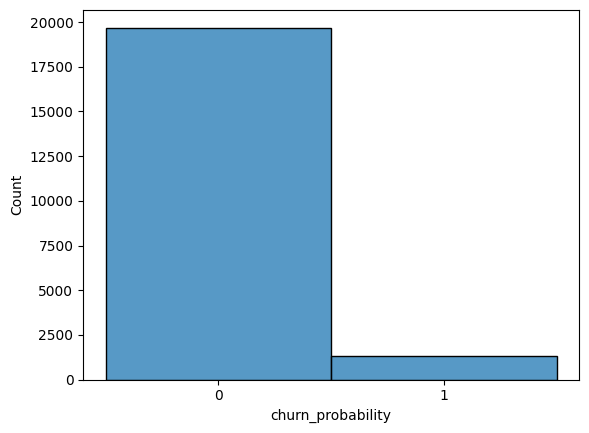

In [51]:
### Understanding target variable

sns.histplot(df_train['churn_probability'].map(str))

#### *Inference*
- As can be seen from the plot, the train dataset target variable value is not balanced.
- The non-churn customers are more than the churn customers
- The dataset needs to be balanced for it to classify the data appropriately
- This imbalance will be handled in the model prep step


#### **6.1.2 - Outlier Analysis**

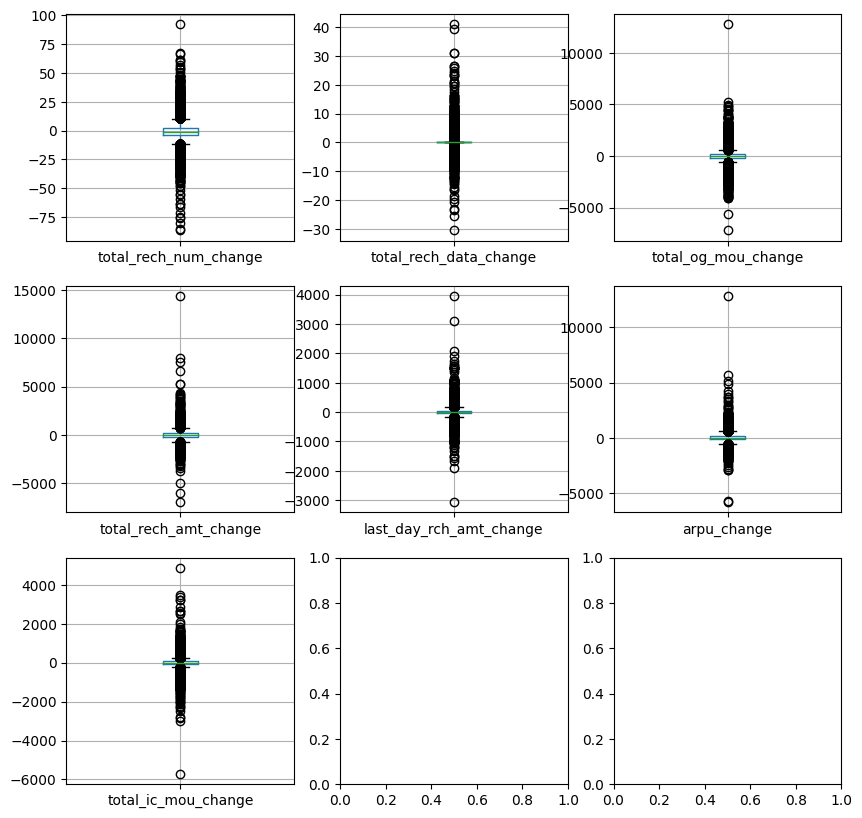

In [52]:


categorical_columns=['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                     'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                     'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                     'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                     'sachet_3g_6','sachet_3g_7','sachet_3g_8']

ordered_numeric_columns=['aon','last_recharge_day_6','last_recharge_day_7','last_recharge_day_8','last_recharge_pattern']

unordered_numeric_columns_totals=['total_rech_num_change','total_rech_data_change','total_og_mou_change',
                           'total_rech_amt_change','last_day_rch_amt_change','arpu_change','total_ic_mou_change']

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i,col in enumerate(unordered_numeric_columns_totals, start=0):
    row = int(i/3)
    column = int(i%3)
    #print(row, column)
    ax = axarr[row,column]  # Access the appropriate subplot from axarr
    df_train.boxplot(column=col,ax=ax)


##### **Outlier Analysis**
##### *Inference*
- There are outliers in almost all the columns.
- Outliers are handled in the next step

#### **6.1.3 - Handle outlier using k-sigmoid method (Referenced sample notebook shared during live session)**

- Outliers are removed from all columns other than the target variable churn_probability


In [53]:
def removeoutliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [54]:
lst_outliers = list(set(df_train.columns) - set(['churn_probability']))
df_train[lst_outliers] = df_train[lst_outliers].apply(removeoutliers, axis=0)

In [55]:
df_train['churn_probability'].value_counts()

0    19695
1     1320
Name: churn_probability, dtype: int64

#### **6.1.4 - Understand any patterns in the following columns**
- age on network
- last recharge during the month

<Axes: xlabel='last_recharge_pattern', ylabel='Count'>

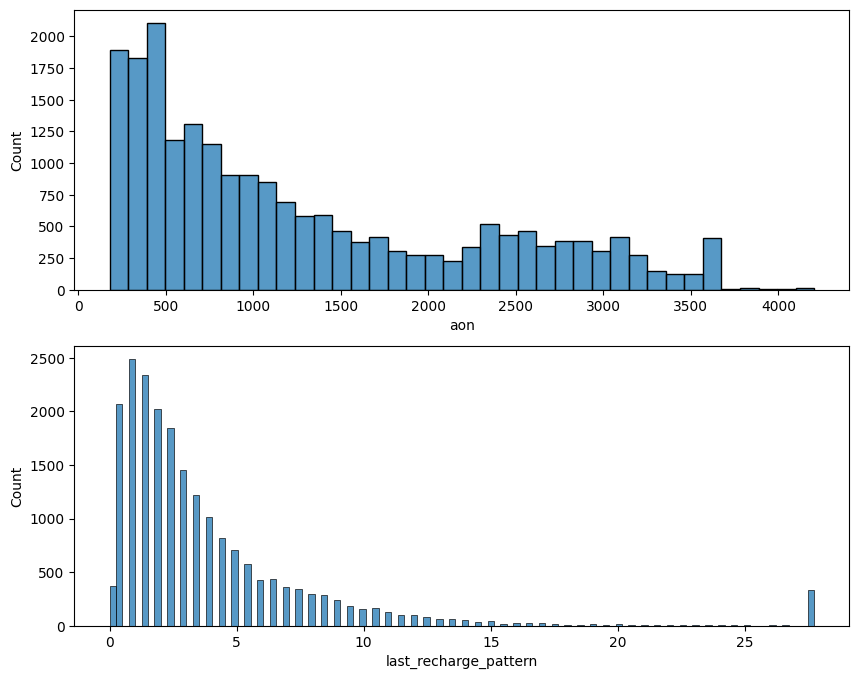

In [56]:
fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
sns.histplot(df_train['aon'],ax=axarr[0])
#sns.histplot(df_train['last_recharge_day_6'],ax=axarr[0,1])
#sns.histplot(df_train['last_recharge_day_7'],ax=axarr[0,2])
#sns.histplot(df_train['last_recharge_day_8'],ax=axarr[1,0])
sns.histplot(df_train['last_recharge_pattern'],ax=axarr[1])

####*Inference*
- It is noticed that more customers have joined the network recently.
- Long term customers are less which means that customers churn out in the longer term
- Most customers recharge during the same period each month. Some of them have adhoc recharge patterns

### **Step 6.2 -  Bivariate Analysis**

**6.2.1 Understand key columns vs churn_probability**
- Group the "total" derived columns by churn_probability and take the mean value
- Represent the data in a bar chart

In [57]:
grouped_data = df_train.groupby('churn_probability').agg({'total_rech_num_change': 'mean','total_rech_data_change': 'mean'
                                                          ,'total_og_mou_change': 'mean', 'total_rech_amt_change' : 'sum'
                                                          ,'last_day_rch_amt_change': 'mean','arpu_change': 'mean'
                                                          ,'total_ic_mou_change': 'mean' })
grouped_data

,total_rech_num_change,total_rech_data_change,total_og_mou_change,total_rech_amt_change,last_day_rch_amt_change,arpu_change,total_ic_mou_change
churn_probability,,,,,,,
0,-0.324108,0.134991,22.260186,406898.326898,4.677890,20.241658,9.397482
1,-5.944485,-0.325503,-495.247930,-540423.616488,-51.206607,-321.719169,-117.903567


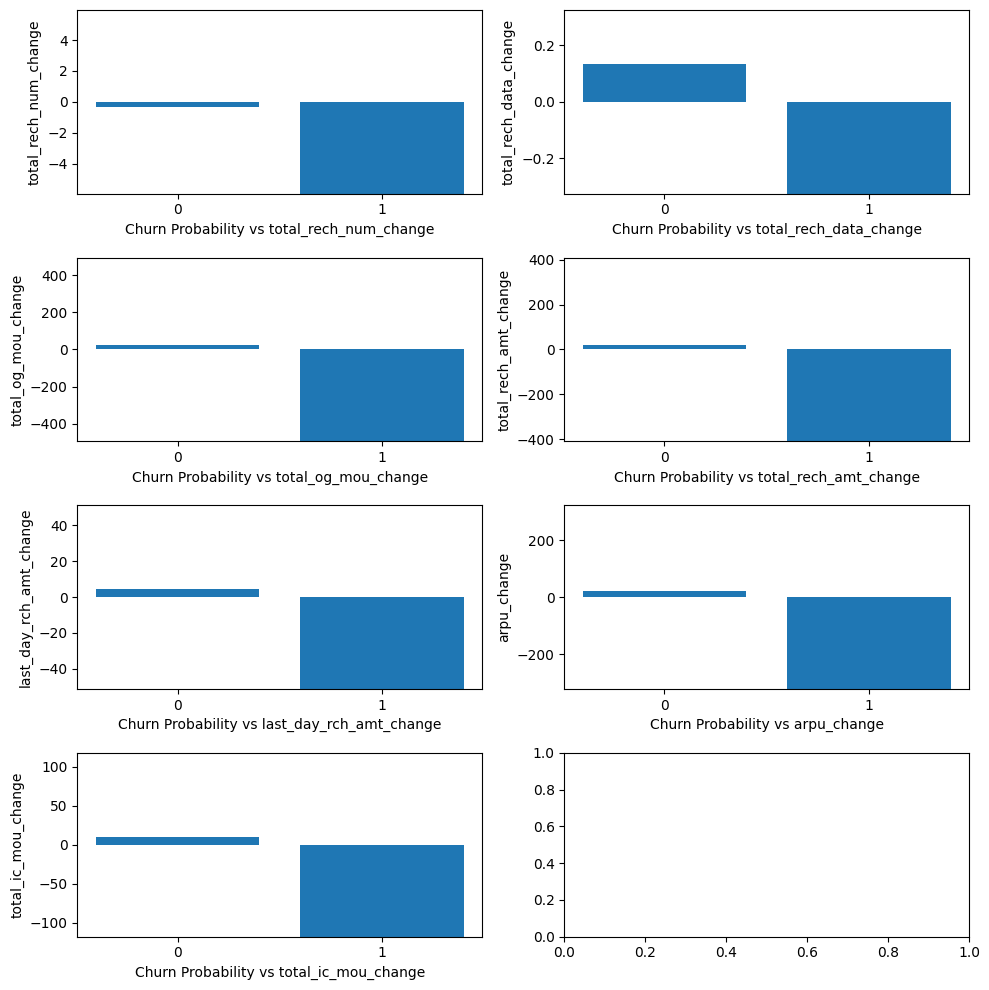

In [58]:
fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

for i,col in enumerate(unordered_numeric_columns_totals, start=0):
    row = int(i/2)
    column = int(i%2)
    ax = axarr[row,column]  # Access the appropriate subplot from axarr
    grouped_data = df_train.groupby('churn_probability', as_index=False).agg({col: 'mean'})
    ymax = max(grouped_data[col])
    ymin = min(grouped_data[col])
    #print(ymax, ymin)
    ylim = max(abs(ymax), abs(ymin))
    ax.bar(grouped_data['churn_probability'].map(str),grouped_data[col])
    ax.set_xlabel('Churn Probability vs ' + col)
    ax.set_ylabel(col)
    ax.set_ylim(-(ylim), ylim)
plt.tight_layout()
plt.show()

####*Inference*

- In all the above charts, it is noticed that the change in the value of the measures is more when churn-probability is 1 compared to the values when churn_probability is 0
- This indicates that any significant change in these columns could be a potential indicator of customer churn

#### **6.2.2 - Correlation Analysis**
- In this section, plot the columns in a correlation matrix to understand if there are columns that are related and can impact the classification model outcome

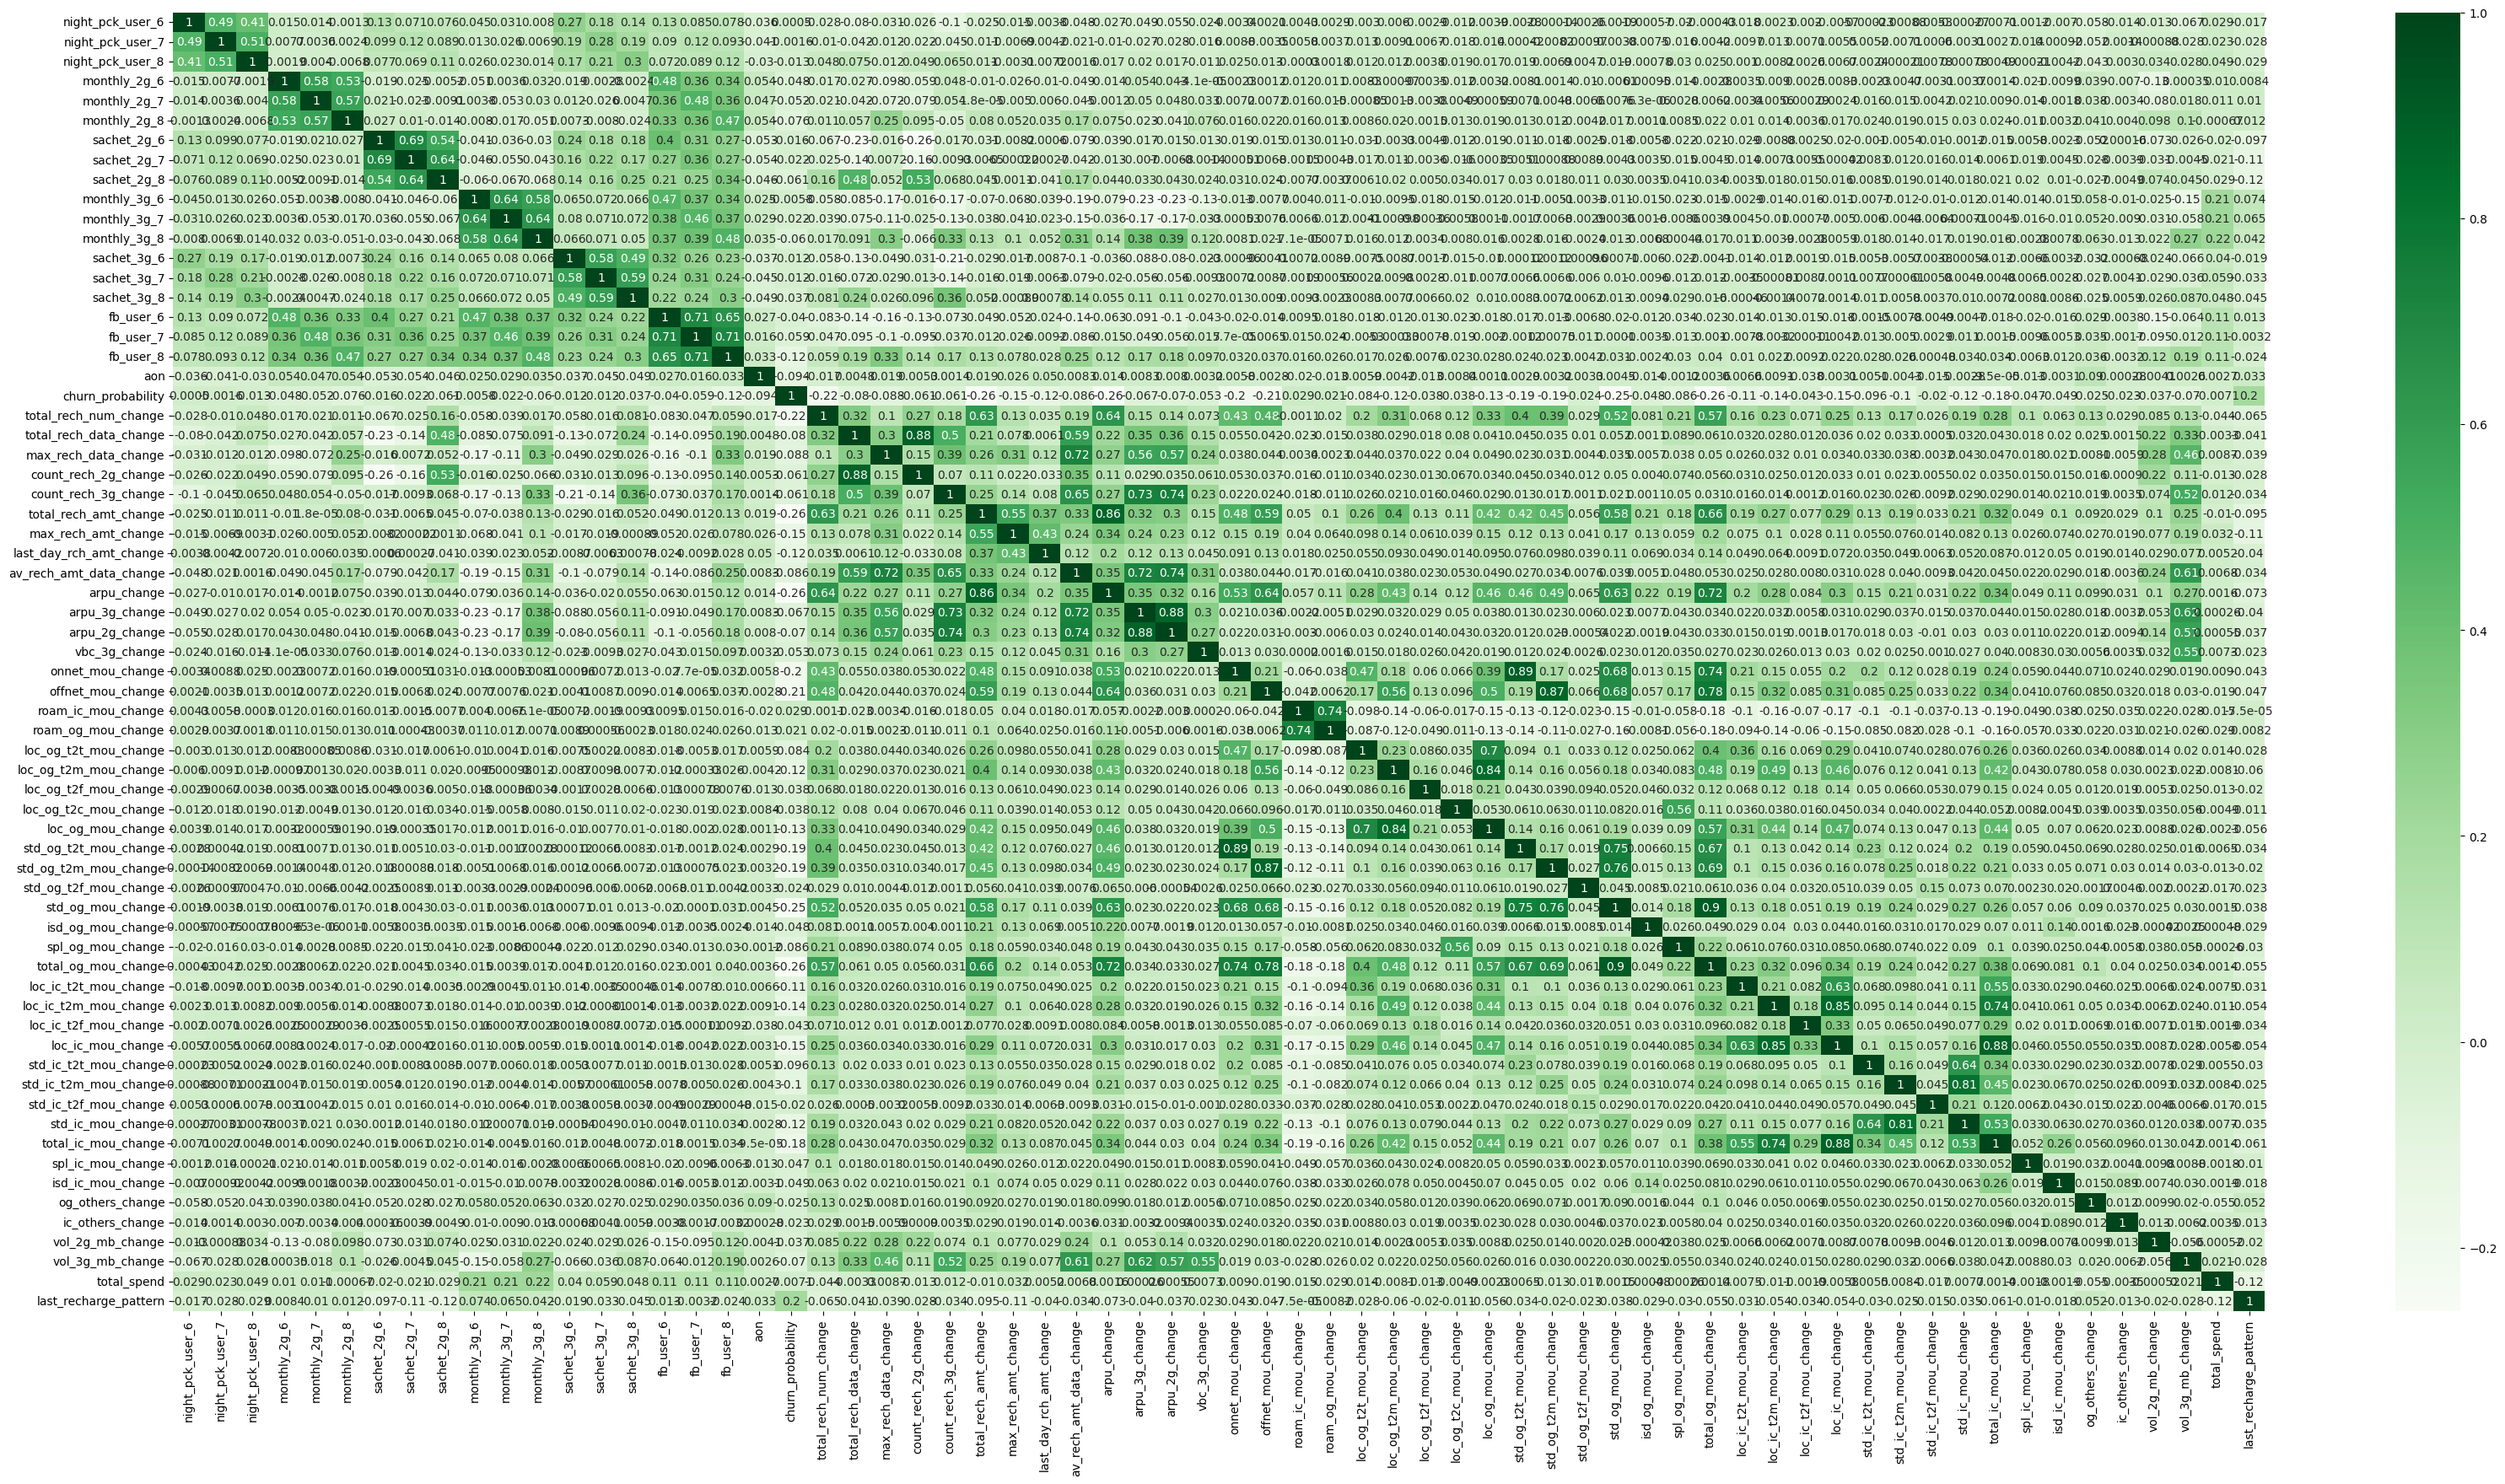

In [59]:
df_train.corr()
fig, ax = plt.subplots(figsize=(40,20))
sns.heatmap(df_train.corr(), cmap="Greens",annot=True, ax=ax)
plt.show()

####*Inference*
- Multiple columns are highly correlated
- For ex -
  - Total_rech_amt_change is highly correlated with arpu_change
onnet_mou_change, std_og_t2t_mou_change
  - PCA will be used as a dimensionality reduction technique and correlated features will be taken care of in PCA

In [60]:
df_train['churn_probability'].value_counts()

0    19695
1     1320
Name: churn_probability, dtype: int64

### **Step 7 - Preparing data for the model build and evaluation**

#### **Step 7.1 - Train Test Split**

In [61]:
#pip install imbalanced-learn

In [62]:
#### Train and Validation Split
y = df_train['churn_probability']
X = df_train.drop('churn_probability', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
print(X_train.shape)
print(X_val.shape)


(14710, 65)
(6305, 65)


#### **7.2 - Apply scaling to numerical columns**
- Numerical variables are identified
- Standard Scalar is used to apply scaling



In [64]:
### Apply scaling to numerical variables

numerical_features = list(set(X_train.columns) - set(categorical_columns))
numerical_features

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

**Step 7.3 - Principal Component Analysis for dimensionality reduction**

- Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional space while retaining most of the original variance.
- For the purpose of the case study, PCA is used to retain 95% of the original variance with reduced dimensionality

In [65]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
print(X_train_pca.shape)
print(X_val_pca.shape)

(14710, 35)
(6305, 35)


#### **Step 7.4 - Balancing the train dataset using SMOTE**
- SMOTE (Synthetic Minority Over-sampling Technique) is a popular method for dealing with imbalanced datasets, where one class is significantly underrepresented compared to the other(s). The algorithm works by generating synthetic samples for the minority class based on the existing data.

In [66]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
print("X Train dataset after PCA - ", X_train_pca.shape)
print("y Train dataset - ", y_train.shape)
print("Resampled X Train dataset - ", X_train_resampled.shape)
print("Resampled y Train dataset - ", y_train_resampled.shape)

X Train dataset after PCA -  (14710, 35)
y Train dataset -  (14710,)
Resampled X Train dataset -  (27596, 35)
Resampled y Train dataset -  (27596,)


#### 7.5 - **Define functions to be used for model prediction**
- createmodel
  - Takes parameters such as estimator algorithm, parameters for the algorithm, folds for K-fold, scoring metric to be used, X train dataset, y train dataset
  - Uses StratifiedKFold method and GridSearchCV to identify the best model based on the parameters provided
  - The best model as determined by GridSearcCV is returned

- predictandcalculatemodelmetrics
  - Takes model, X dataset to be predicted and Y data to be used to used to calculate model metrics
  - Predicts the dataset using the best model identified in createmodel method
  - calculates and displays model metrics such as accuracy, confusion matrix, recall, F1 score, sensitivity, specificity
  - Plots ROC curve and also calculates AUC

In [67]:
def createmodel(estimatoralgorithm, paramvalues, foldscount, scoringmetric,X,y):
    # create 5 folds
    folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

    # create gridsearch object
    model = GridSearchCV(estimator=estimatoralgorithm, cv=foldscount, param_grid=paramvalues, scoring=scoringmetric, n_jobs=-1, verbose=1)

    # fit model
    model.fit(X, y)
    print("Best AUC: ", model.best_score_)
    print("Best hyperparameters: ", model.best_params_)
    bestmodel = model.best_estimator_
    return bestmodel

def  predictandcalculatemodelmetrics(model,y,X):

    y_pred = model.predict(X)

    # Display accuracy, recall, f1 score, and confusion matrix

    confusionmatrix = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n")
    print(confusionmatrix)
    print("\n")

    # calculate sensitivity
    TP = confusionmatrix[1, 1]
    FN = confusionmatrix[1, 0]
    sensitivity = TP / (TP + FN)

    # calculate specificity
    TN = confusionmatrix[0, 0]
    FP = confusionmatrix[0, 1]
    FN = confusionmatrix[1, 0]
    TP = confusionmatrix[1, 1]
    specificity = TN / (TN + FP)
    fnr = FN/ (FN + TP)

    print("Best Score : \n")
    print('Accuracy score:\t', accuracy_score(y, y_pred))
    print('ROCAUC score:\t', roc_auc_score(y, y_pred))
    print('F1 score:\t', f1_score(y, y_pred))
    print('Precision:\t', precision_score(y, y_pred))
    print("Sensitivity / recall:\t", sensitivity)
    print("Specificity:\t", specificity)
    print('False Negative Rate:\t', fnr)

    # Check area under curve
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred_prob.shape
    print("AUC:\t", round(roc_auc_score(y, y_pred_prob), 2))
    print("\n\n")
    # Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


###Step **8 - Building Models**

In the previous steps, it was determined that the training dataset is imbalanced.

The following models are considered for classification
- Logistic Regression
- Logistic Regression with dimensionality reduced(PCA) train dataset
- Logistic Regression with PCA dataset and SMOTE for balancing the dataset
- Logistic Regression with Hyperparameter tuning
- Random Forest with Hyperparmeter tuning

The following metrics is used to evaluate the model

- **Accuracy Score** - measures the proportion of correctly predicted outcomes (both churn and non-churn) out of all instances in the dataset. It gives an overall view of the model's correctness in its predictions.

- **ROCAUC** - provides insights into the model's ability to discriminate between the positive class (churn) and the negative class (non-churn) by plotting the true positive rate (sensitivity) against the false positive rate at different thresholds.A higher ROC-AUC indicates that the model has a better ability to distinguish between churn and non-churn instances.

- **Precision** - measures the accuracy of positive predictions made by the model, specifically focusing on the correct identification of churners among those predicted to churn.

- **Sensitivity/Recall** - Recall focuses on minimizing false negatives, which means the model's ability to correctly identify customers who are likely to churn.

- **F1 score** - combining both precision and recall into a single metric. The F1 score provides a balanced view of a model's performance, particularly when dealing with imbalanced datasets where one class (e.g., churners) is much smaller than the other class (e.g., non-churners).

- **Specificity** - measures the ability of the model to correctly identify non-churn instances (true negatives) among all instances that are actually non-churn.

- **False Negative Rate (FNR)** - quantifies the rate at which the model fails to identify instances that are actually churners.

- **AUC** - measures the overall discriminatory power of a binary classification model, indicating how well the model can distinguish between the positive class (churn) and the negative class (non-churn).

#### **Step 8.1 - Basic Logistic Regression**
- Starting model building and evaluation with the basic logistic regression algorithm
- The train dataset is used as is
- The model is evaluated against the train dataset as well as the validation dataset and accuracy scores and other metrics calculated for both

In [68]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_val)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy score - Train - ", accuracy_train)
print("Accuracy score - Validation -", accuracy)

Accuracy score - Train -  0.9428280081577158
Accuracy score - Validation - 0.9370340999206979


#### **Step 8.2 - Logistic Regression with reduced dimensionality using PCA**
- Principal Component Analysis (PCA) was done in the earlier step
- The train dataset is now limited to the columns from the output of PCA (38 columns)
- The model is evaluated against the train dataset as well as the validation dataset and accuracy scores and other metrics calculated for both

Predicting on Training dataset - 
Confusion Matrix:

[[13696   102]
 [  746   166]]


Best Score : 

Accuracy score:	 0.9423521414004079
ROCAUC score:	 0.5873125840765125
F1 score:	 0.2813559322033899
Precision:	 0.6194029850746269
Sensitivity / recall:	 0.18201754385964913
Specificity:	 0.9926076242933759
False Negative Rate:	 0.8179824561403509
AUC:	 0.84





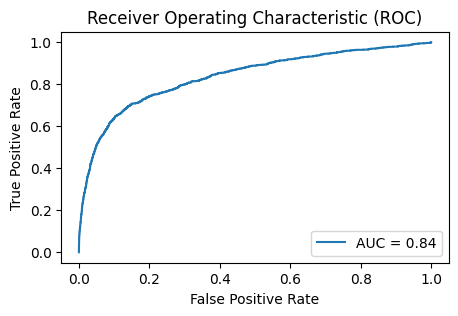

Predicting on Validation dataset - 
Confusion Matrix:

[[5852   45]
 [ 353   55]]


Best Score : 

Accuracy score:	 0.9368754956383822
ROCAUC score:	 0.5635864613778359
F1 score:	 0.21653543307086615
Precision:	 0.55
Sensitivity / recall:	 0.13480392156862744
Specificity:	 0.9923690011870443
False Negative Rate:	 0.8651960784313726
AUC:	 0.84





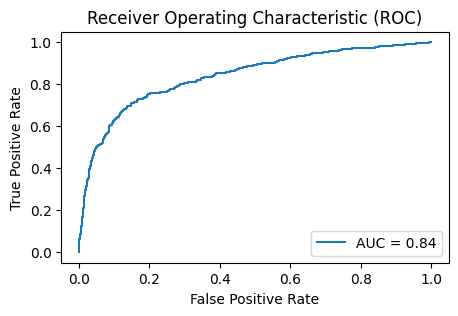

In [69]:
lr_model = LogisticRegression()
lr_model.fit(X_train_pca, y_train)

print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(lr_model,y_train,X_train_pca)
print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(lr_model,y_val,X_val_pca)


#### **Step 8.3 - Logistic Regression with reduced dimensionality using PCA and class weights to handle imbalance in the dataset**
- Principal Component Analysis (PCA) was done in the earlier step
- The train dataset is now limited to the columns from the output of PCA (38 columns)
- In order to handle the imbalance in the dataset, weights are assigned to the classes in the churn probability column.
- The model is evaluated against the train dataset as well as the validation dataset and accuracy scores and other metrics calculated for both

Class Weights -  [0.53304827 8.06469298]
Predicting on Training dataset - 
Confusion Matrix:

[[11115  2683]
 [  236   676]]


Best Score : 

Accuracy score:	 0.8015635622025833
ROCAUC score:	 0.773389799691285
F1 score:	 0.31655350035120583
Precision:	 0.20125037213456387
Sensitivity / recall:	 0.7412280701754386
Specificity:	 0.8055515292071315
False Negative Rate:	 0.25877192982456143
AUC:	 0.84





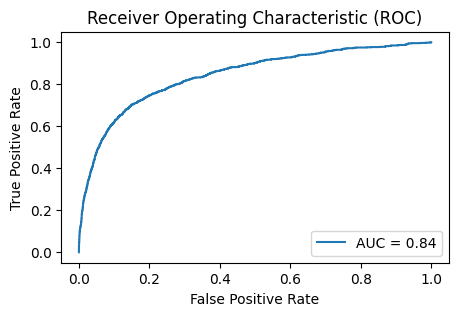

Predicting on Validation dataset - 
Confusion Matrix:

[[4740 1157]
 [ 107  301]]


Best Score : 

Accuracy score:	 0.7995241871530532
ROCAUC score:	 0.7707718198352769
F1 score:	 0.32261521972132906
Precision:	 0.20644718792866942
Sensitivity / recall:	 0.7377450980392157
Specificity:	 0.803798541631338
False Negative Rate:	 0.2622549019607843
AUC:	 0.84





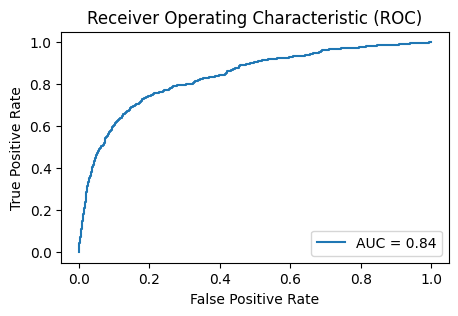

In [70]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights - ", class_weights)

lrcw_model = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})
lrcw_model.fit(X_train_pca, y_train)

print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(lrcw_model,y_train,X_train_pca)
print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(lrcw_model,y_val,X_val_pca)

#### **Step 8.4 - Logistic Regression with reduced dimensionality using PCA and balanced dataset using SMOTE**
- Principal Component Analysis (PCA) was done in the earlier step
- The train dataset is now limited to the columns from the output of PCA (38 columns)
- In this iteration, the train dataset used is balanced by using the SMOTE technique
- The model is evaluated against the train dataset as well as the validation dataset and accuracy scores and other metrics calculated for both

Predicting on Training dataset - 
Confusion Matrix:

[[10957  2841]
 [  237   675]]


Best Score : 

Accuracy score:	 0.7907545887151598
ROCAUC score:	 0.7671160866181979
F1 score:	 0.3048780487804878
Precision:	 0.19197952218430034
Sensitivity / recall:	 0.7401315789473685
Specificity:	 0.7941005942890274
False Negative Rate:	 0.2598684210526316
AUC:	 0.84





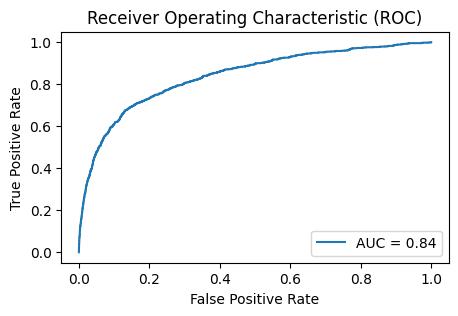

Predicting on Validation dataset - 
Confusion Matrix:

[[4676 1221]
 [ 106  302]]


Best Score : 

Accuracy score:	 0.7895321173671689
ROCAUC score:	 0.7665708219865868
F1 score:	 0.3127912998446401
Precision:	 0.19829284307288247
Sensitivity / recall:	 0.7401960784313726
Specificity:	 0.792945565541801
False Negative Rate:	 0.25980392156862747
AUC:	 0.83





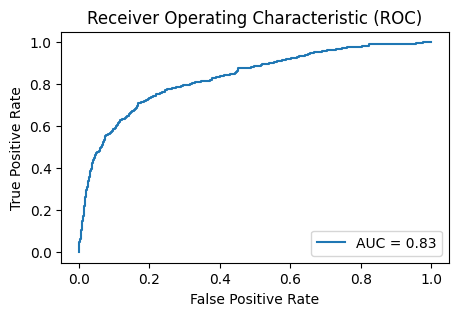

In [71]:
lrsmote_model = LogisticRegression()
lrsmote_model.fit(X_train_resampled, y_train_resampled)
y_pred_train = lrsmote_model.predict(X_train_pca)
y_pred = lrsmote_model.predict(X_val_pca)

print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(lrsmote_model,y_train,X_train_pca)
print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(lrsmote_model,y_val,X_val_pca)

#### **Step 8.5 - Logistic Regression with reduced dimensionality using PCA, balanced dataset using class weights and Hyperparameter tuning using GridSearchCV**
- In this iteration, the train dataset with reduced dimensionality is used along with class weights to handle imbalance in the dataset
- In addition to the above, multiple hyperparameters are passed to the model to evaluate the best combination of parameters using GridSearchCV
- The model is evaluated against the train dataset as well as the validation dataset and accuracy scores and other metrics calculated for both

##### Step 8.5.1 - Hyperparameters Used
- 'penalty': ['l1', 'l2']
  - This hyperparameter specifies the regularization penalty to be applied in the logistic regression model. It can take two possible values: 'l1' and 'l2'. 'l1' stands for L1 regularization (Lasso), which adds the absolute value of the coefficient as a penalty term. 'l2' stands for L2 regularization (Ridge), which adds the square of the coefficient as a penalty term.
- C : [0.1, 0.5, 1, 2, 3, 4, 5, 10]
  - This hyperparameter is the inverse of the regularization strength. It controls how much the model is regularized. The C hyperparameter takes a list of candidate values [0.1, 1.0, 10.0]. Smaller values of C result in stronger regularization, meaning the model will be more penalized for large coefficients, and vice versa for larger C values.
- solver: ['lbfgs', 'liblinear', 'saga']
  - The algorithm used to optimize the model's parameters. Common choices include 'lbfgs' (Limited-memory Broyden-Fletcher-Goldfarb-Shanno), 'liblinear', 'newton-cg', 'saga', etc. Each solver has its own strengths and may perform differently depending on the dataset size and characteristics.
- max_iter:[10,50,100]
  - The maximum number of iterations or epochs the solver is allowed to run to converge to the optimal solution.

In [72]:
# logistic regression - the class weight is used to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights - ", class_weights)

model = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})

# hyperparameters tuning
params = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10]
          , 'solver': ['lbfgs', 'liblinear', 'saga']
          , 'penalty': ['l1', 'l2']
          , 'max_iter':[10,50,100]}

# Call createmodel function to use GridSearchCV to find the optimal model parameters
bestmodel = createmodel(model,params,5,'accuracy',X_train_pca,y_train)

Class Weights -  [0.53304827 8.06469298]
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best AUC:  0.8021753908905506
Best hyperparameters:  {'C': 5, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}


Predicting on Training dataset - 
Confusion Matrix:

[[11120  2678]
 [  238   674]]


Best Score : 

Accuracy score:	 0.8017675050985724
ROCAUC score:	 0.7724744941422987
F1 score:	 0.31613508442776733
Precision:	 0.20107398568019094
Sensitivity / recall:	 0.7390350877192983
Specificity:	 0.8059139005652993
False Negative Rate:	 0.26096491228070173
AUC:	 0.84





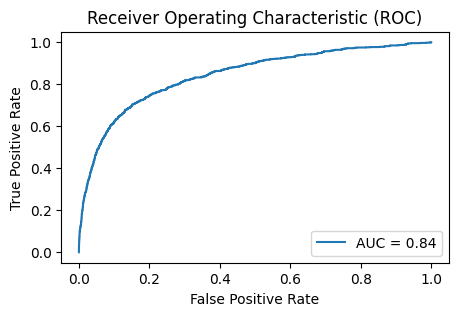

Predicting on Validation dataset - 
Confusion Matrix:

[[4741 1156]
 [ 107  301]]


Best Score : 

Accuracy score:	 0.7996827914353688
ROCAUC score:	 0.7708566087109764
F1 score:	 0.3227882037533512
Precision:	 0.2065888812628689
Sensitivity / recall:	 0.7377450980392157
Specificity:	 0.8039681193827369
False Negative Rate:	 0.2622549019607843
AUC:	 0.84





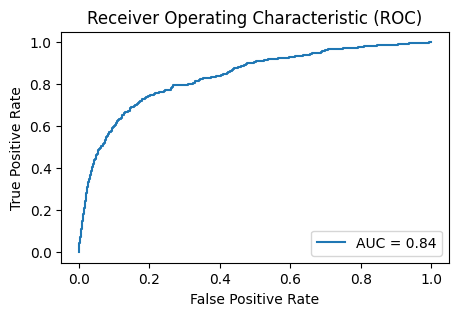

In [73]:
print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_train,X_train_pca)

print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_val,X_val_pca)

#### **Step 8.6 - Random Forest with Hyperparameter Tuning**
- In this iteration, random forest ensemble model is used to train the model and evaluate it against the validation dataset
- The training dataset is the one that has reduced dimensionality (PCA)
- RandomForestClassifier helps in identifying the important features that has higher impact on the outcome of the model
- Hyperparameters are used to tune the model using GridSearchCV which helps to find the best set of parameters
- Model is trained using the best parameters and is evaluated against the validation data



**8.6.1 - PCA dataset + Hyperparameter Tuning**
- n_estimators : [100, 300]
  - This hyperparameter determines the number of decision trees to be used in the Random Forest ensemble.
- max_features:[10, 20]
  - This hyperparameter specifies the maximum number of features to consider when looking for the best split during the construction of each tree.
- max_depth: [10, 20]
  - This hyperparameter controls the maximum depth of each decision tree in the ensemble. It limits the number of levels in each tree.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best AUC:  0.94418762746431
Best hyperparameters:  {'max_depth': 10, 'max_features': 20, 'n_estimators': 100}
Predicting on Training dataset - 
Confusion Matrix:

[[13796     2]
 [  439   473]]


Best Score : 

Accuracy score:	 0.970020394289599
ROCAUC score:	 0.7592477011669629
F1 score:	 0.6820475847152128
Precision:	 0.9957894736842106
Sensitivity / recall:	 0.518640350877193
Specificity:	 0.9998550514567328
False Negative Rate:	 0.48135964912280704
AUC:	 0.95





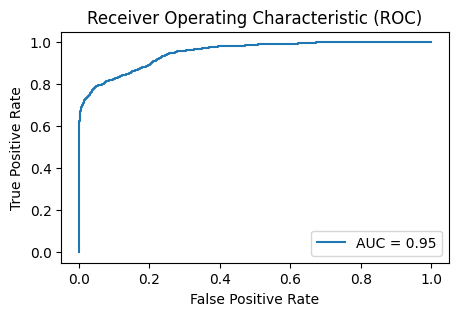

Predicting on Validation dataset - 
Confusion Matrix:

[[5864   33]
 [ 350   58]]


Best Score : 

Accuracy score:	 0.9392545598731166
ROCAUC score:	 0.5682803984744652
F1 score:	 0.23246492985971942
Precision:	 0.6373626373626373
Sensitivity / recall:	 0.14215686274509803
Specificity:	 0.9944039342038324
False Negative Rate:	 0.8578431372549019
AUC:	 0.84





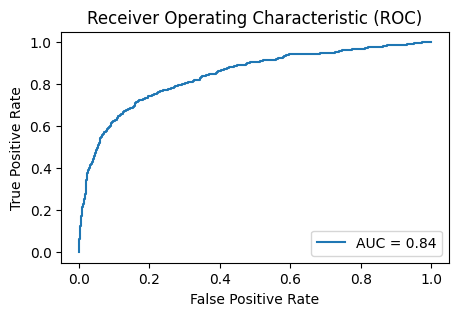

In [74]:
## Random Forest

rfmodel = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 300],
    'max_features':[10, 20],
    'max_depth': [10, 20]
}

bestmodel = createmodel(rfmodel,params,5,'accuracy',X_train_pca,y_train)

print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_train,X_train_pca)

print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_val,X_val_pca)

**8.6.1 - Full dataset + Hyperparameter Tuning**
- n_estimators : [100, 300]
  - This hyperparameter determines the number of decision trees to be used in the Random Forest ensemble.
- max_features:[10, 20]
  - This hyperparameter specifies the maximum number of features to consider when looking for the best split during the construction of each tree.
- max_depth: [10, 20]
  - This hyperparameter controls the maximum depth of each decision tree in the ensemble. It limits the number of levels in each tree.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best AUC:  0.9465669612508497
Best hyperparameters:  {'max_depth': 10, 'max_features': 20, 'n_estimators': 300}
Predicting on Training dataset - 
Confusion Matrix:

[[13782    16]
 [  363   549]]


Best Score : 

Accuracy score:	 0.9742352141400408
ROCAUC score:	 0.8004070479321945
F1 score:	 0.7433987813134733
Precision:	 0.9716814159292035
Sensitivity / recall:	 0.6019736842105263
Specificity:	 0.9988404116538628
False Negative Rate:	 0.3980263157894737
AUC:	 0.98





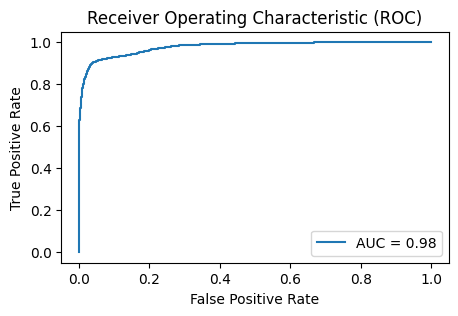

Predicting on Validation dataset - 
Confusion Matrix:

[[5856   41]
 [ 322   86]]


Best Score : 

Accuracy score:	 0.942426645519429
ROCAUC score:	 0.6019158129590652
F1 score:	 0.3214953271028037
Precision:	 0.6771653543307087
Sensitivity / recall:	 0.2107843137254902
Specificity:	 0.9930473121926403
False Negative Rate:	 0.7892156862745098
AUC:	 0.89





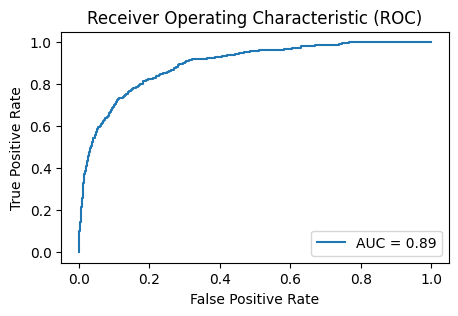

In [75]:
## Random Forest

rfmodel = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 300],
    'max_features':[10, 20],
    'max_depth': [10, 20]
}

bestmodel = createmodel(rfmodel,params,5,'accuracy',X_train,y_train)
print("Predicting on Training dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_train,X_train)

print("Predicting on Validation dataset - ")
predictandcalculatemodelmetrics(bestmodel,y_val,X_val)

**Finding Important Features**

In [87]:
params = {'max_depth': 10, 'max_features': 20, 'n_estimators': 100}
rfmodel = RandomForestClassifier(max_depth=10,max_features=20,n_estimators=100,random_state=42)
rfmodel.fit(X_train, y_train)
y_pred = rfmodel.predict(X_val)

### Finding important features from random forest classifier
importances = rfmodel.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top important features
print("Important Features: ")
print(feature_importance_df.head())



Important Features: 
                  Feature  Importance
24  total_rech_amt_change    0.109240
28            arpu_change    0.091515
35     roam_og_mou_change    0.049515
64  last_recharge_pattern    0.039960
34     roam_ic_mou_change    0.039166


### **Summary of evaluated models**

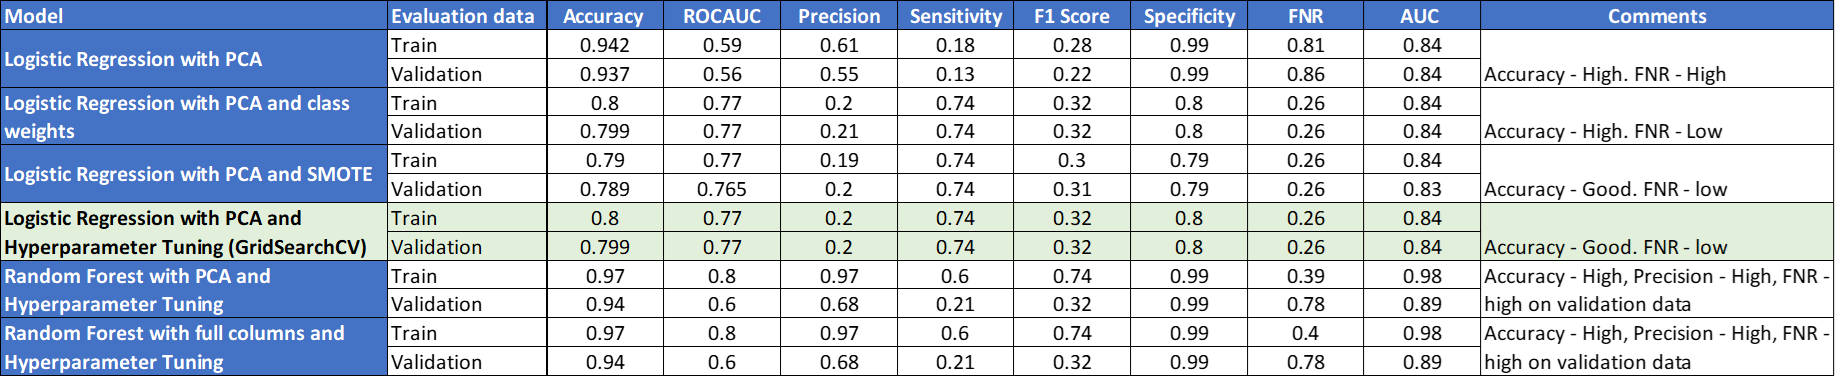

## **Model Recommendations based on evaluation metrics**

### **Step 9 - Evaluating the model with test data**
- Read test.cv into a dataframe
- Preprocess the test.csv data to handle nulls, derive columns etc similar to the preprocessing that was done to the train dataset
- Scale the numerical features using the standard scaler that was used to fit the train data\n
- Principal Component Analysis on the test dataset based on the PCA used to fit the train dataset
- Create a RandomForestClassifier using the optimal hyperparameters determined in the previous step


#### **Step 9.1 - Read test (unseen) data**

In [76]:
pd.set_option('display.max_columns', None)
df_test = pd.read_csv("test.csv")
print(df_test.shape)

(30000, 171)


#### **Step 9.2 - Preprocessing test (unseen) dataset**

In [77]:
print("Preprocessing Test Dataset")
df_test_final = preprocessdata(df_test, "test")
X_test = df_test_final.copy()
print(X_test.shape)

Preprocessing Test Dataset
(30000, 171)
Shape after handling high cardinality columns - (30000, 170)
Shape after handling low cardinality columns - (30000, 157)
Shape after handling columns with NULLs - (30000, 154)
Shape after handling date column formats - (30000, 154)
Shape after deriving new columns - (30000, 199)
Shape after dropping redundant columns - (30000, 67)
Shape after deriving new column for last recharge pattern - (30000, 65)
(30000, 65)


##### **Step 9.3 - Scaling of numerical features in unseen dataset**

In [78]:
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

##### **Step 9.4 - Principal Component Analysis on unseen dataset**

In [79]:
X_test_pca = pca.transform(X_test)

#### **Step 9.5 - Evaluate model using the above trained models**

##### **9.5.1 - Logistic Regression Best Parameters with all columns**

In [80]:
params = {'C': 5, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
lr = LogisticRegression(C=5,max_iter=10,penalty='l2',solver='saga',random_state=42)
lr.fit(X_train_pca, y_train)

LogisticRegression(C=5, max_iter=10, random_state=42, solver='saga')

In [81]:
y_test_pred = lr.predict(X_test_pca)
df_test['churn_probability'] = y_test_pred
testpred = df_test[['id','churn_probability']]
testpred.to_csv('submission_lr.csv',index=False)

##### **9.3.2 - Random Forest Best Parameters with reduced dimensions (PCA)**

In [82]:
params = {'max_depth': 10, 'max_features': 20, 'n_estimators': 100}
rfmodel_trainpca = RandomForestClassifier(max_depth=10,max_features=20,n_estimators=100,random_state=42)
rfmodel_trainpca.fit(X_train_pca, y_train)
y_pred_test_pca = rfmodel_trainpca.predict(X_test_pca)

In [83]:
df_test['churn_probability'] = y_pred_test_pca
testpred = df_test[['id','churn_probability']]
testpred.to_csv('submission_testdatapca.csv',index=False)

##### **9.3.3 - Random Forest Best Parameters with resampled data (SMOTE)**

In [84]:
params = {'max_depth': 10, 'max_features': 20, 'n_estimators': 100}
rfmodel_trainpcasmote = RandomForestClassifier(max_depth=10,max_features=20,n_estimators=100,random_state=42)
rfmodel_trainpcasmote.fit(X_train_resampled, y_train_resampled)
y_pred_test_pcasmote = rfmodel_trainpcasmote.predict(X_test_pca)

In [85]:
df_test['churn_probability'] = y_pred_test_pcasmote
testpred = df_test[['id','churn_probability']]
testpred.to_csv('submission_testdatasmote.csv',index=False)
df_test.drop(['churn_probability'], axis=1)


#### **Recommendations to manage customer churn**


Below table suggests the top features contributing to the classification

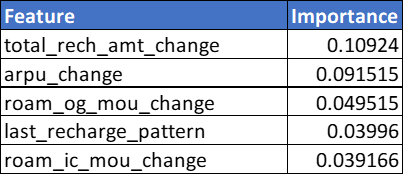

- Providing attactive offers to high value customers in terms of recharge amount, roaming etc
- Providing attractive offers during a customers' regular recharge days in the month.
- Providing competive rates for higher usage on the network
- Assign relationship managers and maintain regular communication with high value customers
- Analyse the market and customer emotions and provide value added services to high value customers